#### Load packages

In [1]:
# %load_ext autotime
## Data pre-processing
import pandas as pd
## Linear Algebra
import numpy as np
## Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
## Date/time manipulation
from datetime import timedelta

def reset_index_drop_first(data):
    data.reset_index(inplace=True)
    data.drop(columns=["index"],inplace=True)

#### Load data

In [2]:
df_dengue = pd.read_excel("Dengue_trends_AM_111.xls")

# Sort datewise
df_dengue.sort_values(by=["Date"],inplace=True); reset_index_drop_first(df_dengue)

df_dengue.head()

,Date,Dengue CDC,dengue searches
0,2004-01-01,98,-0.649
1,2004-02-01,41,-0.645
2,2004-03-01,53,-0.369
3,2004-04-01,92,-0.485
4,2004-05-01,100,0.188


#### A) : Plot the number of cases of Dengue as a function of time.
Let y = Number of cases of dengue and X = time (in year). Expressing y = f(X) as:

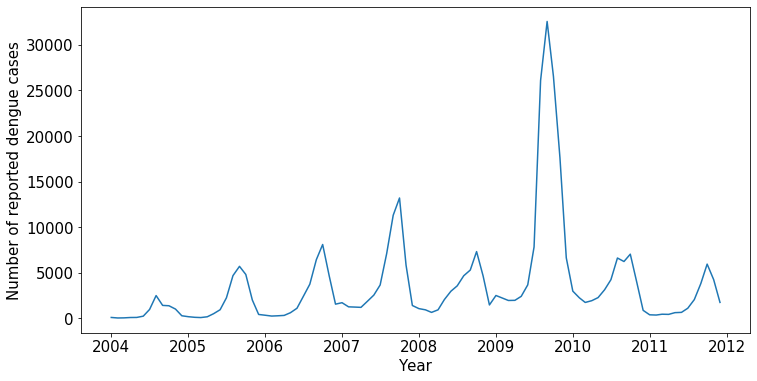

In [3]:
plt.rcParams.update({"font.size":15})
plt.rcParams["figure.figsize"] = (12,6)
sns.lineplot(x=df_dengue["Date"],
 y=df_dengue["Dengue CDC"])
plt.xlabel("Year")
plt.ylabel("Number of reported dengue cases")
plt.show()

#### Partition data into training and validation sets such that:
Training set : Data collected from years 2004 to 2006 (inclusive)
Validation set : Data collected from years 2007 to 2011 (inclusive)

In [4]:
df_dengue_train = df_dengue[(df_dengue["Date"].dt.year>=2004)&
 (df_dengue["Date"].dt.year<=2006)]
df_dengue_validation = df_dengue[(df_dengue["Date"].dt.year>=2007)&
 (df_dengue["Date"].dt.year<=2011)]

#### (B) : For the training period 2004-2006 (36 months), find the best line that explains the number of cases of Dengue as a function of the number of searches of the term “dengue”. You should do this by solving the least squares problem, and you should obtain the value of the y-intercept and the slope.

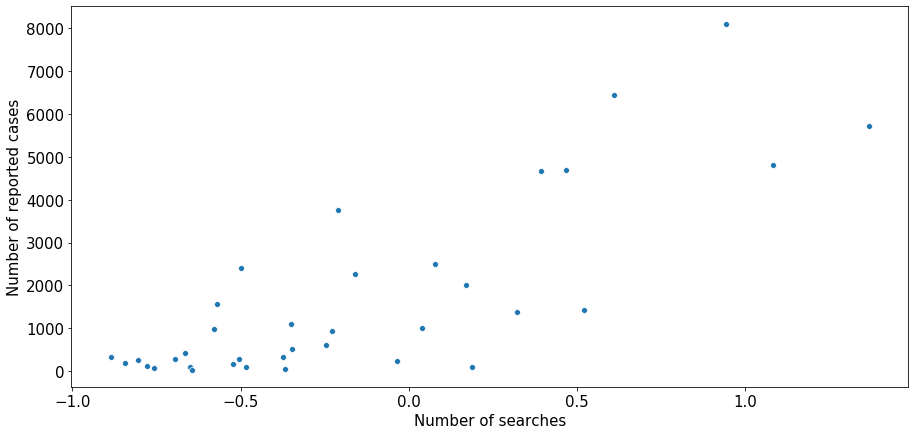

In [5]:
plt.rcParams.update({"font.size":15})
plt.rcParams["figure.figsize"] = (15,7)
sns.scatterplot(y=df_dengue_train["Dengue CDC"],
 x=df_dengue_train["dengue searches"])
plt.xlabel("Number of searches")
plt.ylabel("Number of reported cases")
plt.show()

In [6]:
def best_fit_regression(X, y):
    """Function to calculate slope and intercept of the best fitted line using least squar
     X = Array of independant variables (int64 or float64),
     y = Array of dependant variables (int64 or float64)"""
    # Calculate slope and intercept using least squares method
    m = np.divide(((len(X)*np.sum(X*y)) - (np.sum(X)*np.sum(y))),
                  ((len(X)*np.sum(X**2) - (np.sum(X)**2))))
    c = (np.sum(y)-(m*np.sum(X)))/len(X)
    return m, c

fitted_model = best_fit_regression(X=df_dengue_train["dengue searches"],
 y=df_dengue_train["Dengue CDC"])
print("Slope of the best fitted line is = ",fitted_model[0])
print("y-intercept of the best fitted line is = ",fitted_model[1])

Slope of the best fitted line is =  2926.3789873501105
y-intercept of the best fitted line is =  2155.251813714477


#### (C) : Use the equation of the line you obtained in (b) and plot the number of cases as a function of the number of searches of the term “dengue”, predicted by your method during the training period. Compare your results to the plot in (a) for such time period.


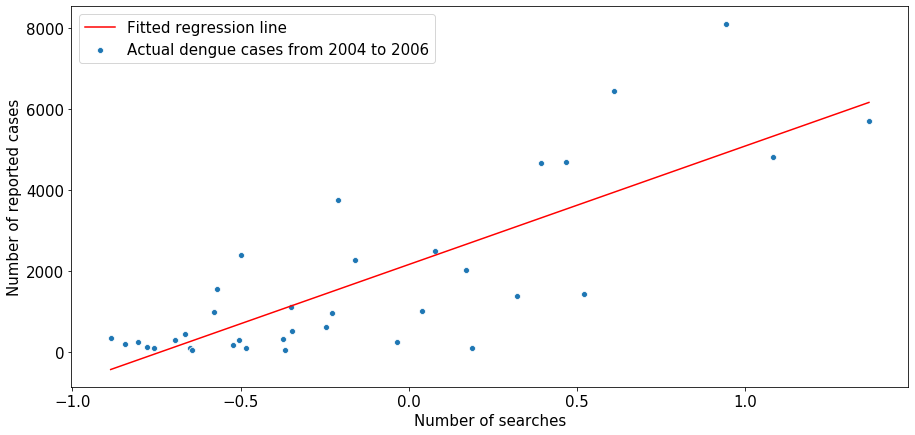

In [7]:
plt.rcParams.update({"font.size":15})
plt.rcParams["figure.figsize"] = (15,7)
sns.scatterplot(x=df_dengue_train["dengue searches"],
 y=df_dengue_train["Dengue CDC"],
 label="Actual dengue cases from 2004 to 2006")
sns.lineplot(x=df_dengue_train["dengue searches"],
 y=fitted_model[0]*df_dengue_train["dengue searches"]+fitted_model[1],
 color="r",
 label="Fitted regression line")
plt.xlabel("Number of searches")
plt.ylabel("Number of reported cases")
plt.show()

#### (D) : For the prediction or validation period 2007-2011, use the equation of the line you obtained in (b) to predict the number of the dengue cases as a function of the number of searches of the term “dengue” from 2007-2011. Plot your predictions and compare them to the actual number of cases.

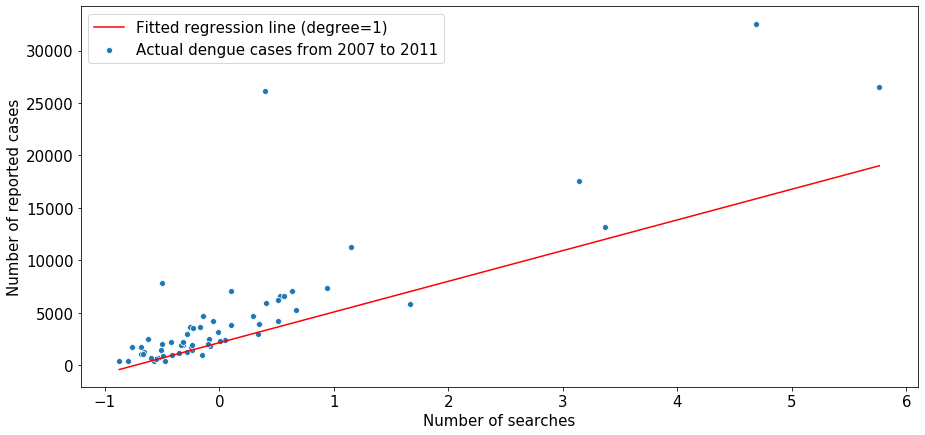

In [8]:
plt.rcParams.update({"font.size":15})
plt.rcParams["figure.figsize"] = (15,7)
sns.scatterplot(x=df_dengue_validation["dengue searches"],
 y=df_dengue_validation["Dengue CDC"],
 label="Actual dengue cases from 2007 to 2011")
sns.lineplot(x=df_dengue_validation["dengue searches"],
 y=fitted_model[0]*df_dengue_validation["dengue searches"]+fitted_model[1],
 color="r",
 label="Fitted regression line (degree=1)")
plt.xlabel("Number of searches")
plt.ylabel("Number of reported cases")
plt.show()

The above fitted model has tried its best to capture the trend based on training data. But, the model's
performance on the test data tells a different story. Further, from the figure obtained in part (A), we can
see that the number of reported dengue cases spike up at specific periods in any given year. The
model even though has captured the trend wel , it hasn't been able to capture the 'seasonality' in the
data based on the time-series. Thus our next approach should be designed in a way to encapsulate the
seasonal variation of dengue episodes in every year.

Prescribed approach: Use ACF or Auto-Correlation Function to measure the correlation between
records seperated by time lags.

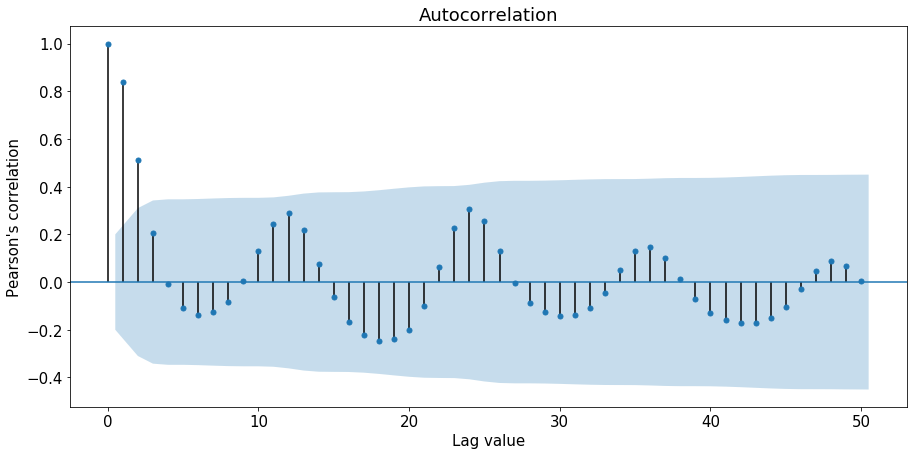

In [9]:
from statsmodels.graphics import tsaplots
tsaplots.plot_acf(df_dengue["Dengue CDC"], lags=50)
plt.xlabel("Lag value")
plt.ylabel("Pearson's correlation")
plt.show()


The above Autocorrelation plot, plots the lag value along the horizontal X axis and the correlation
coefficient on the vertical y-axis. The shaded region represents the confidence interval which is set to
95% by default. Any value that lies outside of this confidence interval, suggest that there exists a
strong correlation at that lag value.
Interpretation: In the above ACF plot, we can see at lag value = 2 months and lag value = 3 months, the
correlation values lie outside of the confidence interval. Thus if we want to predict the number of
dengue cases at any given month in a year, we can use the centered moving average method with an
ideal time lag of previous 2 or 3 months.

In [10]:
## Adding columns MA_2_Dengue_CDC, MA_3_Dengue_CDC, MA_4_Dengue_CDC to forecast moving average
df_dengue["MA_2_Dengue_CDC"] = df_dengue["Dengue CDC"].rolling(window=2).mean()
df_dengue["MA_3_Dengue_CDC"] = df_dengue["Dengue CDC"].rolling(window=3).mean()
df_dengue["MA_4_Dengue_CDC"] = df_dengue["Dengue CDC"].rolling(window=4).mean()
df_dengue["MA_5_Dengue_CDC"] = df_dengue["Dengue CDC"].rolling(window=5).mean()

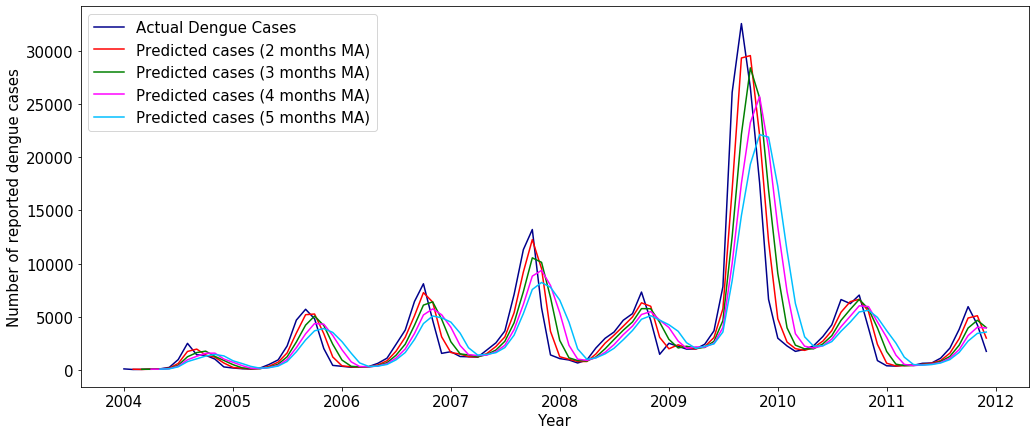

In [11]:
plt.rcParams.update({"font.size":15})
plt.rcParams["figure.figsize"] = (17,7)
sns.lineplot(x=df_dengue["Date"],
 y=df_dengue["Dengue CDC"],
 label="Actual Dengue Cases",
 color="darkblue")
sns.lineplot(x=df_dengue["Date"],
 y=df_dengue["MA_2_Dengue_CDC"],
 label="Predicted cases (2 months MA)",
 color="red")
sns.lineplot(x=df_dengue["Date"],
 y=df_dengue["MA_3_Dengue_CDC"],
 label="Predicted cases (3 months MA)",
 color="green")
sns.lineplot(x=df_dengue["Date"],
 y=df_dengue["MA_4_Dengue_CDC"],
 label="Predicted cases (4 months MA)",
 color="magenta")
sns.lineplot(x=df_dengue["Date"],
 y=df_dengue["MA_5_Dengue_CDC"],
 label="Predicted cases (5 months MA)",
 color="deepskyblue")
plt.xlabel("Year")
plt.ylabel("Number of reported dengue cases")
plt.show()

In the above diagram, we can conclude that a centered moving average of time lag = 2 months fits
closely to the actual reported number of dengue cases as compared to time lag of 3 or 4 months. Thus,
using this approach we can obtain the best fit by incorporating the seasonal trend in the data using
ACF and centered moving average technique.